In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) # My Drive
# Change to your local path if needed
import os

Mounted at /content/gdrive


Drive for Code: https://drive.google.com/drive/folders/1-5hXs1sRm5pEZucITSQ9xk68zFAiJpZA?usp=sharing  

Drive for Dataset: https://drive.google.com/drive/folders/1-3JIhpRF97VD6ZvgHub0r9iSfMzyODKg?usp=sharing  


In [ ]:
import os

# os.chdir('/content')
CODE_DIR = '/content/gdrive/MyDrive/courses/CS275/TediGAN'
if not os.path.exists(CODE_DIR):
  !git clone https://github.com/weihaox/TediGAN.git $CODE_DIR
os.chdir(CODE_DIR)
MODEL_DIR = os.path.join('base', 'models', 'pretrain')
os.makedirs(MODEL_DIR, exist_ok=True)

# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

# download pretrained stylegan and encoder
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EXqix_JIEgtLl1FXI4uCkr8B5GPaiJyiLXL6cFbdcIKqEA?e=WYesel\&download\=1 -O $MODEL_DIR/styleganinv_ffhq256_encoder.pth  --quiet
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EbuzMQ3ZLl1AqvKJzeeBq7IBoQD-C1LfMIC8USlmOMPt3Q?e=CMXn8W\&download\=1 -O $MODEL_DIR/styleganinv_ffhq256_generator.pth  --quiet
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EQJUz9DInbxEnp0aomkGGzAB5b3ZZbtsOA-TXct9E4ONqA?e=smtO0T\&download\=1 -O $MODEL_DIR/vgg16.pth  --quiet

!nvidia-smi
!pip install -r requirements.txt

Sat Jun 18 05:12:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd /content/gdrive/MyDrive/courses/CS275/TediGAN/base
%ls

/content/gdrive/MyDrive/courses/CS275/TediGAN/base
examples/  invert.py  models/  results/  streamlit_app.py  utils/


python invert.py --image_path=examples/29133.jpg --model_name=styleganinv_ffhq256 --mode='man' --description=f'He is angry and narrow lips and arched eyebrows' --learning_rate=0.01 --num_iterations=200 --loss_weight_clip=2.5
python invert.py --image_path=results/inversion/test/29133_inv.png --model_name=styleganinv_ffhq256 --mode='man' --description=f'He is angry and narrow lips and arched eyebrows' --learning_rate=0.01 --num_iterations=100 --loss_weight_clip=2.0
python invert.py --image_path=results/inversion/test/29133_inv_inv.png --model_name=styleganinv_ffhq256 --mode='man' --description=f'He is angry and narrow lips and arched eyebrows' --learning_rate=0.01 --num_iterations=50 --loss_weight_clip=1.5
python invert.py --image_path=results/inversion/test/29133_inv_inv_inv.png --model_name=styleganinv_ffhq256 --mode='man' --description=f'He is angry' --learning_rate=0.01 --num_iterations=50 --loss_weight_clip=1.0


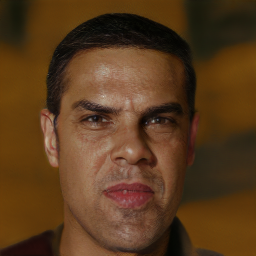

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os
emotion = "anger"
gender = "He"
descr_dict = {"joy":["The person is smiling and mouth open","The person has mouth slightly open","The person is smiling","The person is smiling"],
              "sadness":['The person is sad and crying and bags under eyes' ,'The person is sad and crying and bags under eyes' ,"The person is sad and crying with arched eyebrows and narrow lips","The person is sad and crying with arched eyebrows and narrow lips"],
              "anger":['The person is angry and narrow lips and arched eyebrows','The person is angry and narrow lips and arched eyebrows',"The person is angry and narrow lips and arched eyebrows","The person is angry"],
              "love":['The person is in love, smiling and arched eyebrows','The person is in love, smiling and narrow lips','The person is in love, smiling and narrow eyes','The person is smiling and narrow eyes'],
              "fear":['The person is afraid and scared, has mouth slightly open and big eyes and sad','The person is afraid and scared, has mouth slightly open and big eyes and sad','The person is afraid and scared, has big eyes, mouth slightly open and sad' ,'The person is afraid, has big eyes and smiling and sad'  ],
              "surprise":['The person is surprised, smiling and mouth open and big eyes','The person is surprised, smiling and big eyes','The person is surprised, smiling and big eyes','The person is smiling and big eyes' ]}
og_dict = {"joy":"The person is happy","sadness":"The person is sad","anger":"The person is angry","love":"The person is in love","fear":"The person is afraid","surprise":"The person is surprised"}
clip_rate_list = [2.5,2.0,1.5,1.0]
iter_list = [200,100,50,50]
show_orig=True
image_path = "examples/29133.jpg"  #MAKE SURE THE CORRESPONDING image is in your examples folder
model_name = "styleganinv_ffhq256"
img_name = image_path[image_path.index("/")+1:image_path.index(".")]

impath_list = [image_path,"results/inversion/test/"+img_name+"_inv.png", "results/inversion/test/"+img_name+"_inv_inv.png", "results/inversion/test/"+img_name+"_inv_inv_inv.png" ]
desc_list = descr_dict[emotion]
initial = image_path
final = "results/inversion/test/"+img_name+"_inv_inv_inv_enc.png"
for i in range(len(desc_list)):
  desc = desc_list[i].replace("The person",gender)
  clip = clip_rate_list[i]
  iter = iter_list[i]
  command = "python invert.py --image_path={} --model_name={} --mode='man' --description=f'{}' --learning_rate=0.01 --num_iterations={} --loss_weight_clip={}".format(impath_list[i], model_name, desc, iter, clip)
  print(command)
  os.system(command)
result_image = cv2.imread(final)  #Output image is HERE

# og_desc = og_dict[emotion].replace("The person",gender)
# command = "python invert.py --image_path={} --model_name={} --mode='man' --description=f'{}' --learning_rate=0.01 --num_iterations={} --loss_weight_clip={}".format(image_path, model_name, og_desc, 200, 2.0)
# print(command)
# os.system(command)
# og_image = cv2.imread("results/inversion/test/"+img_name+"_inv.png")

# cv2_imshow(og_image)
cv2_imshow(result_image)